In [3]:
import pandas as pd
import random as rnd 
import mysql.connector
from mysql.connector import Error
import plotly
import json
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pymysql
import plotly.express as px
import plotly.graph_objects as go
from sqlalchemy import create_engine
import networkx as nx
from networkx_viewer import Viewer
from functools import reduce
from scipy.spatial.distance import pdist, squareform
import jgraph
from cyjupyter import Cytoscape
from scipy.stats import kendalltau
from scipy.stats import weightedtau
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

In [4]:
connection = mysql.connector.connect(host='127.0.0.1',
                                         database='employment',
                                         user='root',
                                         password='thanhn123')

In [5]:
def get_data(connection, descriptor_domain,filt = False,val = None):
    '''
    Return df in the SOCs-decriptor format of a specific domain 
    descriptor_domeain:
        work context
        knowledge
        skills
        gwas
        job_zones, filter
        Abilities, filter
    
    '''
    df= pd.DataFrame(data=None)
    if descriptor_domain == 'work_context':
        df= pd.read_sql('''
            SELECT title, element_name, data_value FROM employment.work_context
            LEFT JOIN employment.content_model_reference USING (element_id) 
            LEFT JOIN employment.occupation_data USING (onetsoc_code)
            WHERE scale_id LIKE 'CX';''', con = connection)
        df = df.reset_index().pivot(index = 'title', columns = 'element_name', values = 'data_value')
    elif descriptor_domain == 'job_zones':
        if filt:
            df= pd.read_sql('''
                SELECT title,job_zone FROM employment.job_zones
                LEFT JOIN employment.occupation_data USING (onetsoc_code); ''', con = connection)
            df = df[df['job_zone'].isin(val)]
        else:
            df= pd.read_sql('''
                SELECT title,job_zone FROM employment.job_zones
                LEFT JOIN employment.occupation_data USING (onetsoc_code);''', con = connection)
    elif descriptor_domain == 'abilities':
        if filt:
#             df= pd.read_sql('''
#             SELECT title, element_name, element_id,data_value FROM employment.''' + descriptor_domain + '''
#             LEFT JOIN employment.content_model_reference USING (element_id) 
#             LEFT JOIN employment.occupation_data USING (onetsoc_code); ''', con = connection)
#             df = df[df['element_id'].contains(val)]
            df= pd.read_sql('''
            SELECT title, element_name, data_value FROM employment.''' + descriptor_domain + '''
            LEFT JOIN employment.content_model_reference USING (element_id) 
            LEFT JOIN employment.occupation_data USING (onetsoc_code)
            WHERE element_id LIKE\''''+ val +'''%\'; ''', con = connection)
            
        else:
            df= pd.read_sql('''
            SELECT title, element_name,element_id, data_value FROM employment.''' + descriptor_domain + '''
            LEFT JOIN employment.content_model_reference USING (element_id) 
            LEFT JOIN employment.occupation_data USING (onetsoc_code);''', con = connection)
        df = df.groupby(by=['title','element_name'])['data_value'].mean()
        df = df.reset_index().pivot(index = 'title', columns = 'element_name', values = 'data_value')
    elif descriptor_domain == 'work_values':
        df= pd.read_sql('''
            SELECT title, element_name, data_value FROM employment.work_values
            LEFT JOIN employment.content_model_reference USING (element_id) 
            LEFT JOIN employment.occupation_data USING (onetsoc_code)
            WHERE scale_id LIKE 'EX';''', con = connection)
        df = df.reset_index().pivot(index = 'title', columns = 'element_name', values = 'data_value')
    elif descriptor_domain == 'interests':
        df= pd.read_sql('''
            SELECT title, element_name, data_value FROM employment.interests
            LEFT JOIN employment.content_model_reference USING (element_id) 
            LEFT JOIN employment.occupation_data USING (onetsoc_code)
            WHERE scale_id LIKE 'OI';''', con = connection)
        df = df.reset_index().pivot(index = 'title', columns = 'element_name', values = 'data_value')
    elif descriptor_domain == 'work_styles':
        df= pd.read_sql('''
            SELECT title, element_name, data_value FROM employment.work_styles
            LEFT JOIN employment.content_model_reference USING (element_id) 
            LEFT JOIN employment.occupation_data USING (onetsoc_code)
            WHERE scale_id LIKE 'IM';''', con = connection)
        df = df.reset_index().pivot(index = 'title', columns = 'element_name', values = 'data_value')
    elif descriptor_domain == 'name':
        df= pd.read_sql('''
            SELECT * FROM employment.occupation_data;''', con = connection)
    else:
        df= pd.read_sql('''
            SELECT title, element_name, data_value FROM employment.''' + descriptor_domain + '''
            LEFT JOIN employment.content_model_reference USING (element_id) 
            LEFT JOIN employment.occupation_data USING (onetsoc_code);''', con = connection)
        df = df.groupby(by=['title','element_name'])['data_value'].mean()
        df = df.reset_index().pivot(index = 'title', columns = 'element_name', values = 'data_value')
    return df

In [6]:
df_cps = pd.read_csv('../CPS Job Changes/JobChanges_2011to19.csv')

In [7]:
df_cps.sort_values(by = 'pct_tot', ascending = False)

,ONET18_SOC_LY,ONET18_SOC,ONET18_Title,ONET18_Title_LY,count,pct_tot,count_socly,pct_socly,in_grp,in_minor_grp,in_broad_occ,employment_projection_NewJob,wage_change_BetweenJobs
75823,41-1011,41-1012,First-Line Supervisors of Non-Retail Sales Wor...,First-Line Supervisors of Retail Sales Workers,734264.510000,4.395486e-01,2207170.940,33.267224,1,1,1,-8.3,85.257732
76141,41-1012,41-1011,First-Line Supervisors of Retail Sales Workers,First-Line Supervisors of Non-Retail Sales Wor...,603472.900000,3.612536e-01,999832.010,60.357429,1,1,1,-5.5,-46.021146
77141,41-2012,41-2031,Retail Salespersons,Gambling Change Persons and Booth Cashiers,509346.270000,3.049071e-01,2630467.290,19.363338,1,1,0,-0.6,-1.700405
76588,41-2011,41-2031,Retail Salespersons,Cashiers,509346.270000,3.049071e-01,2630467.290,19.363338,1,1,0,-0.6,6.772208
177,11-1021,11-1011,Chief Executives,General and Operations Managers,352402.430000,2.109567e-01,751730.590,46.878820,1,1,0,-10.0,83.034056
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88371,45-2092,25-1112,"Law Teachers, Postsecondary","Farmworkers and Laborers, Crop, Nursery, and G...",1.135947,6.800058e-07,184416.524,0.000616,0,0,0,6.9,346.293792
88369,45-2092,25-1082,"Library Science Teachers, Postsecondary","Farmworkers and Laborers, Crop, Nursery, and G...",1.135947,6.800058e-07,184416.524,0.000616,0,0,0,3.0,180.717341
88368,45-2092,25-1081,"Education Teachers, Postsecondary","Farmworkers and Laborers, Crop, Nursery, and G...",1.135947,6.800058e-07,184416.524,0.000616,0,0,0,4.8,157.524058
88367,45-2092,25-1072,"Nursing Instructors and Teachers, Postsecondary","Farmworkers and Laborers, Crop, Nursery, and G...",1.135947,6.800058e-07,184416.524,0.000616,0,0,0,17.6,193.257438


In [8]:
def distance_table(df, jz=False):
    
#     squareform(pdist(df.iloc[:, 1:])), columns=df.title.unique(), index=df.title.unique()
    dist = []
    name_dict = {}
    if jz:
        name_dict = df['title'].sort_values().reset_index()['title'].to_dict()
        dist = pdist(df[df.columns[1:]],'euclidean')
    else:
        for i in range(len(df.index)):
            name_dict[i] = df.index[i]
        dist = pdist(df,'euclidean') #Euclidean distance for 1XN
    df_dist = pd.DataFrame(squareform(dist)) #Euclidean distance for NxN
#     return df_dist
    columns = list(df_dist.index) 
    for i in range(len(df.index)): #convert 0 values to NaN
        df_dist.loc[i,i] = np.NaN
    mean = df_dist.mean().mean()
    std = df_dist.stack().std() 

    for col in columns: #Z-score calculated 
        df_dist[col] = (df_dist[col] - mean)/std
#     return df_dist
    return df_dist.rename(columns = name_dict, index = name_dict)

In [9]:
df_ab = get_data(connection,'abilities')
df_in = get_data(connection,'interests')
df_ws = get_data(connection,'work_styles')
df_wv = get_data(connection, 'work_values')
df_wc = get_data(connection,'work_context')
df_knowledge = get_data(connection,'knowledge')
df_gwas = get_data(connection,'work_activities')
df_jz = get_data(connection,'job_zones')
df_jz = df_jz[df_jz['title'] != 'Legislators']
df_skills = get_data(connection,'skills')



In [10]:
## merged format of distance table

In [11]:
def distance_table2(df,attribute, jz=False):
    
#     squareform(pdist(df.iloc[:, 1:])), columns=df.title.unique(), index=df.title.unique()
    dist = []
    name_dict = {}
    if jz:
        name_dict = df['title'].sort_values().reset_index()['title'].to_dict()
        dist = pdist(df[df.columns[1:]],'euclidean')
    else:
        for i in range(len(df.index)):
            name_dict[i] = df.index[i]
        dist = pdist(df,'euclidean') #Euclidean distance for 1XN
    df_dist = pd.DataFrame(squareform(dist)) #Euclidean distance for NxN
#     return df_dist
    columns = list(df_dist.index) 
    for i in range(len(df.index)): #convert 0 values to NaN
        df_dist.loc[i,i] = np.NaN
    mean = df_dist.mean().mean()
    std = df_dist.stack().std() 

    for col in columns: #Z-score calculated 
        df_dist[col] = (df_dist[col] - mean)/std
    
#     return df_dist
    df_convert = df_dist.rename(columns = name_dict, index = name_dict).stack().reset_index(level=[0,1])
    return df_convert.rename(columns = {'level_0':"occ_1",'level_1':"occ_2",0:attribute})

In [12]:
distance_table2(df_skills,"skills")

,occ_1,occ_2,skills
0,Accountants,Actors,-0.230680
1,Accountants,Actuaries,-1.227414
2,Accountants,Acupuncturists,-1.171535
3,Accountants,Acute Care Nurses,-0.569831
4,Accountants,Adapted Physical Education Specialists,-1.003623
...,...,...,...
936051,Zoologists and Wildlife Biologists,Wind Energy Operations Managers,-0.552562
936052,Zoologists and Wildlife Biologists,Wind Energy Project Managers,-1.141655
936053,Zoologists and Wildlife Biologists,Wind Turbine Service Technicians,0.745142
936054,Zoologists and Wildlife Biologists,"Woodworking Machine Setters, Operators, and Te...",1.480451


In [13]:
wc_dist = distance_table(df_wc)
knowledge_dist = distance_table(df_knowledge)
skills_dist = distance_table(df_skills)
gwas_dist = distance_table(df_gwas)
jz_dist = distance_table(df_jz,True)
wv_dist = distance_table(df_wv)
in_dist = distance_table(df_in)
ab_dist = distance_table(df_ab)
ws_dist = distance_table(df_ws)


In [14]:
### Merging dataframes

In [15]:
wc_dist_stack = distance_table2(df_wc,'work_context')
knowledge_dist_stack = distance_table2(df_knowledge,'knowledge')
skills_dist_stack = distance_table2(df_skills,'skills')
gwas_dist_stack = distance_table2(df_gwas,'GWAs')
jz_dist_stack = distance_table2(df_jz,'job_zones',True)
wv_dist_stack = distance_table2(df_wv,'work_value')
in_dist_stack = distance_table2(df_in,'interests')
ab_dist_stack = distance_table2(df_ab,'abilities')
ws_dist_stack = distance_table2(df_ws,'work_setting')

occ_list = [skills_dist_stack,gwas_dist_stack,jz_dist_stack,wv_dist_stack,in_dist_stack,ab_dist_stack,ws_dist_stack]

In [16]:
merged = wc_dist_stack.merge(knowledge_dist_stack, on = ['occ_1','occ_2'])
for occ in occ_list:
    merged = merged.merge(occ,on = ['occ_1','occ_2'])

In [17]:
final = pd.merge(merged,df_cps[['ONET18_Title_LY','ONET18_Title','pct_socly']], left_on = ['occ_1','occ_2'],right_on = ['ONET18_Title_LY','ONET18_Title'])

In [18]:
final = final.drop(['ONET18_Title_LY','ONET18_Title'],axis = 1)

In [32]:
X = final[['work_context','knowledge','skills','GWAs','job_zones','work_value','interests','abilities','work_setting']]
y = final[['pct_socly']]/100

In [34]:
final

,occ_1,occ_2,work_context,knowledge,skills,GWAs,job_zones,work_value,interests,abilities,work_setting,pct_socly
0,Actors,"Architects, Except Landscape and Naval",-0.918944,1.399400,1.460416,2.470048,-0.279247,0.101742,-0.780752,0.862265,0.764238,0.559267
1,Actors,Art Directors,-0.372115,-0.859354,0.393605,1.421440,-0.279247,-0.095941,-1.715149,0.170214,0.649119,1.202400
2,Actors,Athletes and Sports Competitors,-0.618953,0.004852,-1.058288,1.143995,-0.279247,-0.322521,0.181907,0.771601,-0.058820,0.795582
3,Actors,Choreographers,-1.054168,-2.064155,-0.946549,1.298014,-1.282330,-1.486452,-1.821960,0.327834,-0.411441,3.299395
4,Actors,Coaches and Scouts,-1.598500,-0.457433,0.920534,0.519203,-0.279247,-0.895034,0.354357,-0.492353,-0.140843,0.795582
...,...,...,...,...,...,...,...,...,...,...,...,...
52486,Zoologists and Wildlife Biologists,"Social Work Teachers, Postsecondary",-0.722096,0.939441,-0.810901,-0.332312,-1.282330,-0.116789,0.548314,0.200078,0.634186,0.249838
52487,Zoologists and Wildlife Biologists,Social and Community Service Managers,-1.139182,0.050918,-1.111016,-1.002737,-1.282330,0.244077,1.631101,-0.488000,1.127289,0.178162
52488,Zoologists and Wildlife Biologists,"Sociology Teachers, Postsecondary",-0.489913,0.436966,-0.825876,-0.114027,-1.282330,-0.368363,0.718163,0.285739,0.075186,0.249838
52489,Zoologists and Wildlife Biologists,Soil and Plant Scientists,-2.340171,-1.948193,-1.625445,-2.386685,-1.282330,-0.823751,-1.770247,-1.562761,-0.913837,0.601424


                 Generalized Linear Model Regression Results                  
Dep. Variable:              pct_socly   No. Observations:                52491
Model:                            GLM   Df Residuals:                    52482
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -27160.
Date:                Thu, 15 Oct 2020   Deviance:                       51195.
Time:                        02:14:14   Pearson chi2:                 5.31e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
work_context     0.7007      0.017     41.554   

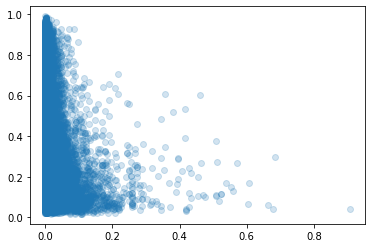

In [36]:
binom_glm = sm.GLM(y, X, family=sm.families.Binomial())
binom_results = binom_glm.fit()
plt.plot(y, binom_results.predict(X), 'o', alpha=0.2);
print(binom_results.summary())

In [133]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.55,random_state=0)

In [135]:
logistic_regression= LogisticRegression()
logistic_regression.fit(X_train,y_train)
# y_pred= logistic_regression.predict(X_test)

/usr/local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


ValueError: Unknown label type: 'continuous'

In [101]:
merged

,occ_1,occ_2,work_context,knowledge,skills,GWAs,job_zones,work_value,interests,abilities,work_setting
0,Accountants,Actors,-0.301552,1.239577,-0.230680,1.065963,-1.282330,-0.294869,1.123841,0.313869,1.815713
1,Accountants,Actuaries,-1.854910,-1.583849,-1.227414,-1.065244,-0.279247,-1.234131,-1.783121,-1.761765,-0.636321
2,Accountants,Acupuncturists,-0.178894,1.313263,-1.171535,0.036929,-0.279247,-1.483345,1.283004,-0.178585,-0.750213
3,Accountants,Acute Care Nurses,0.415972,1.396600,-0.569831,-0.010115,-0.279247,-1.276185,1.341708,-0.526176,1.140320
4,Accountants,Adapted Physical Education Specialists,0.324330,0.399752,-1.003623,-0.482001,-0.279247,-0.785031,0.800617,0.767171,1.166324
...,...,...,...,...,...,...,...,...,...,...,...
934117,Zoologists and Wildlife Biologists,Wind Energy Operations Managers,-1.180460,-0.339722,-0.552562,-1.369941,-1.282330,-0.478418,0.276664,-1.816206,-0.701510
934118,Zoologists and Wildlife Biologists,Wind Energy Project Managers,-1.651128,-0.641303,-1.141655,-1.786276,-1.282330,-0.400571,0.136889,-0.550296,-1.348571
934119,Zoologists and Wildlife Biologists,Wind Turbine Service Technicians,0.260723,-0.212196,0.745142,0.392140,-1.282330,-0.411213,-0.336310,-0.314236,-1.380746
934120,Zoologists and Wildlife Biologists,"Woodworking Machine Setters, Operators, and Te...",0.761242,0.907904,1.480451,2.057422,-1.282330,0.851707,-0.699972,0.134018,-0.442479


In [89]:
df_cps

,ONET18_SOC_LY,ONET18_SOC,ONET18_Title,ONET18_Title_LY,count,pct_tot,count_socly,pct_socly,in_grp,in_minor_grp,in_broad_occ,employment_projection_NewJob,wage_change_BetweenJobs
0,11-1011,11-1021,General and Operations Managers,Chief Executives,327891.330000,0.196284,644769.200000,50.854062,1,1,0,5.8,-45.365359
1,11-1011,11-1031,Legislators,Chief Executives,4069.996250,0.002436,644769.200000,0.631233,1,1,0,6.2,-84.131579
2,11-1011,11-2021,Marketing Managers,Chief Executives,5621.145000,0.003365,644769.200000,0.871807,1,0,0,6.7,-25.811908
3,11-1011,11-2022,Sales Managers,Chief Executives,5621.145000,0.003365,644769.200000,0.871807,1,0,0,3.5,-31.337393
4,11-1011,11-3012,Administrative Services Managers,Chief Executives,1832.805000,0.001097,644769.200000,0.284258,1,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115312,53-7199,53-7065,Stockers and Order Fillers,"Material Moving Workers, All Other",4878.226667,0.002920,43481.721667,11.219028,1,0,0,0.7,-13.874346
115313,53-7199,53-7071,Gas Compressor and Gas Pumping Station Operators,"Material Moving Workers, All Other",35.795833,0.000021,43481.721667,0.082324,1,0,0,-2.1,108.180628
115314,53-7199,53-7072,"Pump Operators, Except Wellhead Pumpers","Material Moving Workers, All Other",35.795833,0.000021,43481.721667,0.082324,1,0,0,9.7,41.688482
115315,53-7199,53-7073,Wellhead Pumpers,"Material Moving Workers, All Other",35.795833,0.000021,43481.721667,0.082324,1,0,0,4.2,73.167539


(a,b)|| # || # || # || = 
y  = a-> b % 

In [9]:
to_drop = ['Fuel Cell Technicians', 'Green Marketers', 'Investment Underwriters',
       'Legislators', 'Methane/Landfill Gas Collection System Operators',
       'Methane/Landfill Gas Generation System Technicians']

In [10]:
# in_dist= in_dist.drop(index = to_drop)
# in_dist = in_dist.drop(columns = to_drop,axis = 1)
# wv_dist= wv_dist.drop(index = to_drop)
# wv_dist = wv_dist.drop(columns = to_drop,axis = 1)


In [11]:
def percentage_default(occ,df_cps,a,b):
    df_occ = df_cps[df_cps['ONET18_Title_LY'] == occ].sort_values(by = 'pct_socly', ascending = False)
    return df_occ[a:b]['pct_socly'].sum()

In [12]:
def percentage(occ,df_onet,df_cps,a,b):
    '''
    Get total percentage that ONET transition takes ups
    @param occ occupation of interests
    @param df_onet dataFrame for ONET
    @param df_cps dataFrame for CPS data
    @param a index of first position for onet
    @param index of last position
    
    return the percentage composition for the ath to bth place of ONET
    '''
    
    total = 0
    onet_list = df_onet.loc[occ].sort_values()[a:b].index.to_list()
    cps_occ = df_cps[df_cps['ONET18_Title_LY'] == occ]
    for occ in onet_list:
#         print(occ)
#         print(cps_occ[cps_occ['ONET18_Title'] == occ]['pct_tot'].values[0])
        val = cps_occ[cps_occ['ONET18_Title'] == occ]['pct_socly'].values
        if len(val) == 0:
            continue
        else:
            total += val[0]
    
    return total

In [13]:
def percentage_coverage(df_onet,df_cps):   
    cps_occ = set(df_cps['ONET18_Title_LY'].unique())
    onet_occ = set(df_onet.index.unique())
    avg_occ = 0
    count = 0
    relevant_occ = cps_occ & onet_occ
#     occ_dictionary = {}
    for occ in relevant_occ:
        cps_len = len(df_cps[df_cps['ONET18_Title_LY'] == occ]['ONET18_Title'])
        if cps_len > 20:
            n = percentage(occ,df_onet,df_cps,0,20)
            d = percentage_default(occ,df_cps,0,20)
            perc = n/d
            count += 1 
            avg_occ += perc
#             occ_dictionary[occ] = perc

    return avg_occ/count

In [14]:
X = np.array([skills_dist.to_numpy(), #skills 0
                       knowledge_dist.to_numpy(), #knowledge 1
                       in_dist.to_numpy(), #interest 2
                       gwas_dist.to_numpy(), #general work activities 3
                       wc_dist.to_numpy(), #work context 4
                       jz_dist.to_numpy(), #job zone 5
                       wv_dist.to_numpy(), #work value 6 
                       ab_dist.to_numpy(),],dtype=object) #abilites  8
#                        ws_dist.to_numpy()],dtype=object) #worksetting 8

In [15]:
mean_X = pd.concat([skills_dist, #skills 
                       knowledge_dist, #knowledge
                       in_dist, #interest
                       gwas_dist, #general work activities
                       wc_dist, #work context
                       jz_dist, #job zone
                       wv_dist, #work value
                       ab_dist,] #abilites
                     ).groupby(level =0).mean()

In [124]:
# l = [skills_dist, #skills 
#                        knowledge_dist, #knowledge
#                        in_dist, #interest
#                        gwas_dist, #general work activities
#                        wc_dist, #work context
#                        jz_dist, #job zone
#                        wv_dist, #work value
#                        ab_dist,]
# test = np.array([0,1,1,1,1,1,1,1,])
# # np.reshape()
# # np.multiply(l,))
# counter = 0
# for a,b in zip(l,test):
#     l[counter] = a*b
#     counter += 1
    
# l

In [17]:
ws_dist.index.difference(skills_dist.index)

Index([], dtype='object')

In [18]:
X[0].shape

(968, 968)

In [19]:
# for i in range(9):
#     print(i)
#     print(X[i].shape)

In [20]:
arr = np.ones(shape = (8,968,968))

In [21]:
# y = np.dot(X,np.array([1,1,1,1,1,1,1,1,1,1,]))
# X * test
X.shape

(8,)

In [22]:
# X
# test =np.dot(X,arr)
# clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=1)
# clf.fit(X, test)

In [23]:
# X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
# y = [0,1,0,1]
# clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=100)
# clf.fit(X, y)
# clf.coef_
# y

In [24]:
onet_ = [skills_dist, #skills 
                       knowledge_dist, #knowledge
                       in_dist, #interest
                       gwas_dist, #general work activities
                       wc_dist, #work context
                       jz_dist, #job zone
                       wv_dist, #work value
                       ab_dist,
                       ws_dist]

In [25]:
def compute_loss(X,th):
    onet_list = X
    counter = 0
    for a,b in zip(X,th):
        onet_list[counter] = a*b
        counter += 1
    df_onet = pd.concat(onet_list).groupby(level=0).mean()
    p = percentage_coverage(df_onet,df_cps)
    return (p-1)**2

In [121]:
# test = np.array([1,1,1,1,1,0,0,1,0])
# compute_loss(onet_,test)

In [250]:
def dJ(X,th):
    grad = [0]*9
    counter = 0
    for a,b in zip(X,th):
#         grad[counter] = percentage_coverage(2*a*(a*b - 1),df_cps)
        grad[counter] = 2*a*(percentage_coverage(a*b,df_cps)-1)
        print(grad[counter])
        counter += 1
    
    return grad
    

In [120]:
# dJ(onet_,test)

In [122]:
# def gradient_descent(J,dJ,max_iter,th):
    
#     th = th
#     th0 = th0
#     step_size = 0.1
#     for i in max_iter:
#         dJ = 
#         th = th - step_size*dJ

In [123]:
# graedient_descent(compute_loss,10,th0,th)